In [1]:
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load(r"../word2vec-google-news-300.model")
print(len(word2vec_model))

3000000


In [2]:

import numpy as np
import json
# this code is taken from online and slightly modified

with open(r"../vocab.json") as f:
    dict = json.load(f)
    word_set = set(dict.keys())
vocab = set(word2vec_model.key_to_index.keys())

def charMapping(word_set):
    final_word_set = set()
    charMap = {}
    for word in vocab:
        if word in word_set:
            charMap[word] = word
            final_word_set.add(word)
        elif word.lower() in word_set:
            charMap[word.lower()] = word
            final_word_set.add(word.lower())
    word_set = final_word_set
    return charMap

def augment_wordset_with_OOV(word_set):
    with open(r"../oovMap.json") as f:
        dict = json.load(f)
        for key in dict:
            words = dict[key]
            for word in words:
                word_set.add(word)
            if key in word_set:
                word_set.remove(key)

def restrict_w2v(w2v, restricted_word_set, handle_oov = False):
    if handle_oov:
        augment_wordset_with_OOV(restricted_word_set)
        charMap = charMapping(restricted_word_set)
    
    new_key_to_index = {} #given word, give index
    new_index_to_key = {} #given index, give word
    new_vectors = []
    
    new_key_to_index["</s>"] = 0
    new_index_to_key[0] = "</s>"
    new_vectors.append([0] * 300)
    
    for word in restricted_word_set:
        if word not in charMap:
            continue
        index = w2v.key_to_index[charMap[word]]
        vec = w2v.vectors[index]
        val = len(new_key_to_index)
        new_key_to_index[word] = val
        new_index_to_key[val] = word
        new_vectors.append(vec)
  
    w2v.key_to_index = new_key_to_index
    w2v.index_to_key = new_index_to_key
    w2v.vectors = new_vectors

restrict_w2v(word2vec_model, word_set, handle_oov=True)
print(len(word2vec_model.vectors))

15583


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        scores = self.attention_weights(x).squeeze(2) 
        weights = F.softmax(scores, dim=1).unsqueeze(2) 
        weighted_output = (x * weights).sum(dim=1)  
        return weighted_output

class SentimentCNN(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, output_size, dropout=0.5):
        super(SentimentCNN, self).__init__()
        self.embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.vectors), freeze=False, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes])
        self.attention = AttentionLayer(num_filters * len(filter_sizes))
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask=None):
        x = self.embed_layer(x).unsqueeze(1)
        conv_outs = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled_outs = [F.max_pool1d(conv_out, conv_out.size(2)).squeeze(2) for conv_out in conv_outs]
        out = torch.cat(pooled_outs, dim=1)
        out = self.attention(out.unsqueeze(1)).squeeze(1)  # Apply attention
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [4]:
with open(r"../oovMap.json") as f:
    oovMap = json.load(f)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class SentimentDataset(Dataset):
    def __init__(self, dataset, word2vec_model, max_length=100):
        self.dataset = dataset
        self.word2vec = word2vec_model
        self.max_length = max_length  # Maximum sequence length for padding

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get text and label
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        
        # Convert text to embeddings
        tokens = text # Assuming text is tokenized already
        embeddings = []
        # print(tokens)
        for word in tokens:
            if word in self.word2vec:
                embeddings.append(self.word2vec.key_to_index.get(word))
                continue
            if word not in oovMap:
                continue
            for chunk in oovMap[word]:
                embeddings.append(self.word2vec.key_to_index.get(chunk))            
        
        # Truncate sequences - will pad later
        if len(embeddings) > self.max_length:
            embeddings = embeddings[:self.max_length]
        
        if len(embeddings) == 0:
            return self.__getitem__((idx + 1) % len(self.dataset))  # Skip empty sequences
        
        embeddings = np.array(embeddings)
        
        return torch.tensor(embeddings, dtype=torch.int32), torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    '''Creates mini-batch tensors from the list of tuples (embeddings, labels, mask).'''
    
    # Separate embeddings and labels
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Stack them into tensors
    embeddings = pad_sequence(embeddings, batch_first=True) # (B, L, D)
    
    # Create the mask
    mask = (embeddings != 0).float() # (B, L) - 1 if there is a word, 0 if it's a padding
    
    labels = torch.stack(labels)
    
    return embeddings, labels, mask


In [6]:
from datasets import load_from_disk
import gensim.downloader as api
from gensim.models import KeyedVectors

# This is the training dataset
path_to_train_set = r"../tokenised_datasets/tokenised_train_dataset"
train_dataset = load_from_disk(path_to_train_set)
train_data = SentimentDataset(train_dataset, word2vec_model)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)

# Get the same for test and validation
path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, collate_fn=collate_fn)

path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)
val_data = SentimentDataset(val_dataset, word2vec_model)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, collate_fn=collate_fn)


c:\Users\Admin\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Define model parameters
input_size = word2vec_model.vector_size         # Dimension of Word2Vec embeddings
hidden_size = 16        # Number of hidden units
output_size = 1          # Output size (1 for binary classification)
dropout = 0.60        # Dropout rate for regularization


In [8]:
def validate_model(model, val_loader, device, criterion, val_losses=[], val_accuracies=[]):
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for val_embeddings, val_labels, mask in val_loader:
            val_embeddings, val_labels, mask = val_embeddings.to(device), val_labels.to(device), mask.to(device)
            val_outputs = model(val_embeddings, mask).squeeze()
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_labels.size(0)  # Multiply by batch size for total loss
            val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()  # Threshold at 0.5
            val_correct_predictions += (val_predictions == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / val_total_samples
    val_accuracy = val_correct_predictions / val_total_samples
    
    # Store validation metrics for plotting
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    

C:\Users\Admin\AppData\Local\Temp\ipykernel_27844\1199486502.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.vectors), freeze=False, padding_idx=0)
c:\Users\Admin\anaconda3\envs\nlp\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Loss: 0.6913, Accuracy: 0.5369 Validation Accuracy: 0.6351
Epoch 2/100, Loss: 0.6794, Accuracy: 0.6048 Validation Accuracy: 0.6473
Epoch 3/100, Loss: 0.6659, Accuracy: 0.6644 Validation Accuracy: 0.6764
Epoch 4/100, Loss: 0.6524, Accuracy: 0.6917 Validation Accuracy: 0.6811
Epoch 5/100, Loss: 0.6348, Accuracy: 0.7161 Validation Accuracy: 0.7008
Epoch 6/100, Loss: 0.6143, Accuracy: 0.7314 Validation Accuracy: 0.7129
Epoch 7/100, Loss: 0.5892, Accuracy: 0.7546 Validation Accuracy: 0.7308
Epoch 8/100, Loss: 0.5630, Accuracy: 0.7696 Validation Accuracy: 0.7392
Epoch 9/100, Loss: 0.5351, Accuracy: 0.7856 Validation Accuracy: 0.7308
Epoch 10/100, Loss: 0.5070, Accuracy: 0.7923 Validation Accuracy: 0.7402
Epoch 11/100, Loss: 0.4806, Accuracy: 0.8072 Validation Accuracy: 0.7458
Epoch 12/100, Loss: 0.4527, Accuracy: 0.8202 Validation Accuracy: 0.7486
Epoch 13/100, Loss: 0.4312, Accuracy: 0.8306 Validation Accuracy: 0.7580
Epoch 14/100, Loss: 0.4103, Accuracy: 0.8382 Validation Accu

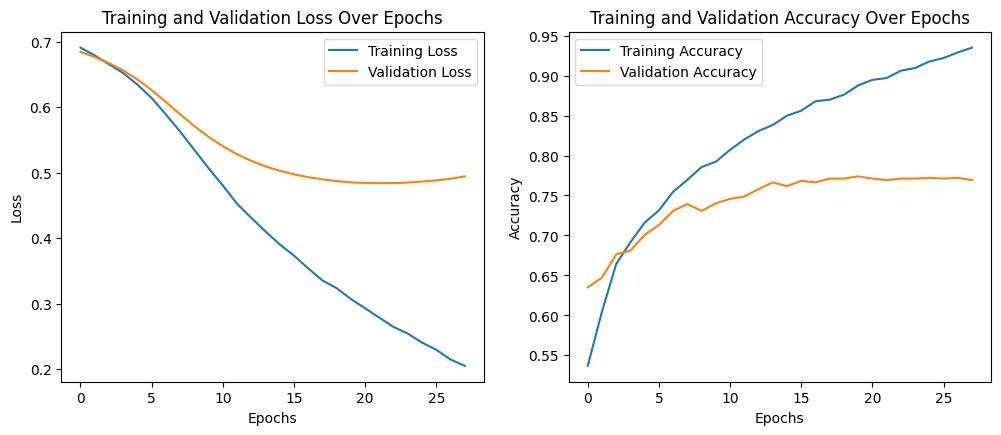

In [9]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Binary Cross-Entropy Loss with Logits
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with the model's parameters and a learning rate
learning_rate = 0.00005

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model parameters
embedding_dim = word2vec_model.vector_size  # Dimension of Word2Vec embeddings
num_filters = 100  # Number of filters per filter size
filter_sizes = [2, 3, 4]  # Filter sizes for convolution (e.g., bigrams, trigrams, etc.)
output_size = 1  # Binary classification
dropout = 0.5  # Dropout rate

# Initialize the model
model = SentimentCNN(embedding_dim, num_filters, filter_sizes, output_size, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# Training parameters
num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Set the model to training mode
    model.train()
    for embeddings, labels, mask in train_loader:
        # Move data to the same device as model (GPU if available)
        embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(embeddings, mask).squeeze()

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss and accuracy
        epoch_loss += loss.item() * labels.size(0)  # Multiply by batch size for total loss
        predictions = (torch.sigmoid(outputs) >= 0.5).float()  # Threshold at 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Store metrics for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}", end=" ")
    validate_model(
        model,
        val_loader,
        device,
        criterion,
        val_losses,
        val_accuracies
    )
    scheduler.step(val_losses[-1])
    # Early stopping: if the moving average validation accuracy has decreased, then stop
    if epoch > 10 and val_accuracies[-1] < np.mean(val_accuracies[-10:-1]):
        print("Early stopping")
        break 

# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


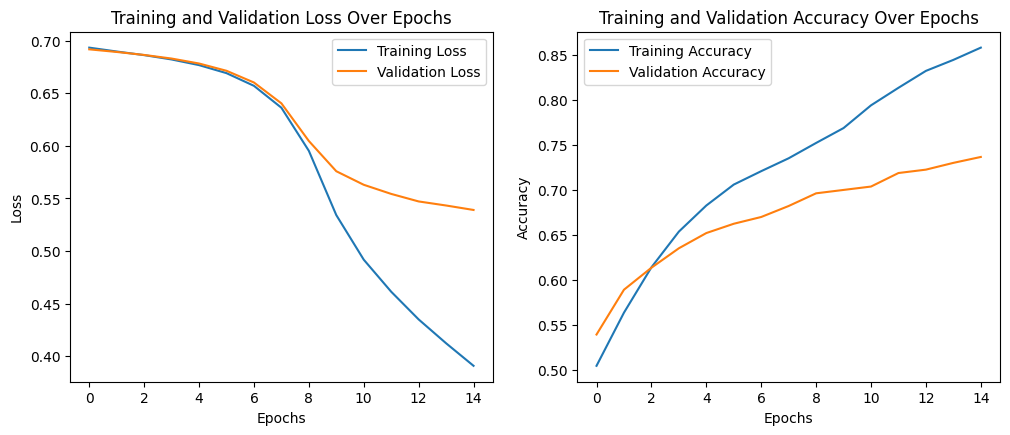

In [ ]:
# Plot the training and validation loss and accuracy over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


In [11]:
# import torch
# # Save the model
torch.save(model.state_dict(), 'sentiment_cnn_activation_{}_{}_with_OOV.pth'.format(hidden_size, str(learning_rate)[2:]))

#load the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout).to(device)
# model.load_state_dict(torch.load('sentiment_rnn_1hl_16_00005_with_OOV.pth'))


In [10]:
from datasets import load_from_disk
from gensim.models import KeyedVectors


# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print('reach')
# This is the word2vec model
# word2vec_model = KeyedVectors.load(r"../word2vec-google-news-300.model")

# Set the model to evaluation mode
model.eval()

test_predictions = []
test_targets = []

# print(len(test_loader))
for i, x in enumerate(test_loader):
    # print(i, end = " ")
    embeddings, labels, mask = x
    # Move data to the same device as model
    embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
    
    # Forward pass
    outputs = model(embeddings, mask).squeeze()
    
    # Store the actual and predicted labels
    predictions = (torch.sigmoid(outputs) >= 0.5).float()
    test_predictions.extend(predictions.tolist())
    test_targets.extend(labels.tolist())
    
# Calculate the test accuracy
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)
test_accuracy = np.mean(test_predictions == test_targets)

print(f"testing accuracy: {test_accuracy:.4f}")

testing accuracy: 0.8011
